# HOMEWORK 5

This homework focuses on the implementation and analysis of the Floyd–Steinberg dithering algorithm for image quantization. The goal is to study the trade-off between numerical accuracy and perceptual image quality when reducing the number of available colors.

## Methodology

The work consists of the following steps:

1. Define a color palette.

2. Quantize the original image using the defined palette to obtain a baseline result.

3. Compute the average quantization error for the baseline image.

4. Implement the Floyd–Steinberg dithering algorithm by diffusing the quantization error to neighboring pixels.

5. Compute the average quantization error for the dithered image.

6. Compare the results numerically (MAE, MSE, PSNR) and visually.

7. Repeat the experiment using different palette sizes (2, 4, 16, 32, 256 colors) and analyze the effect of palette size on image quality.


In [1]:
import cv2
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

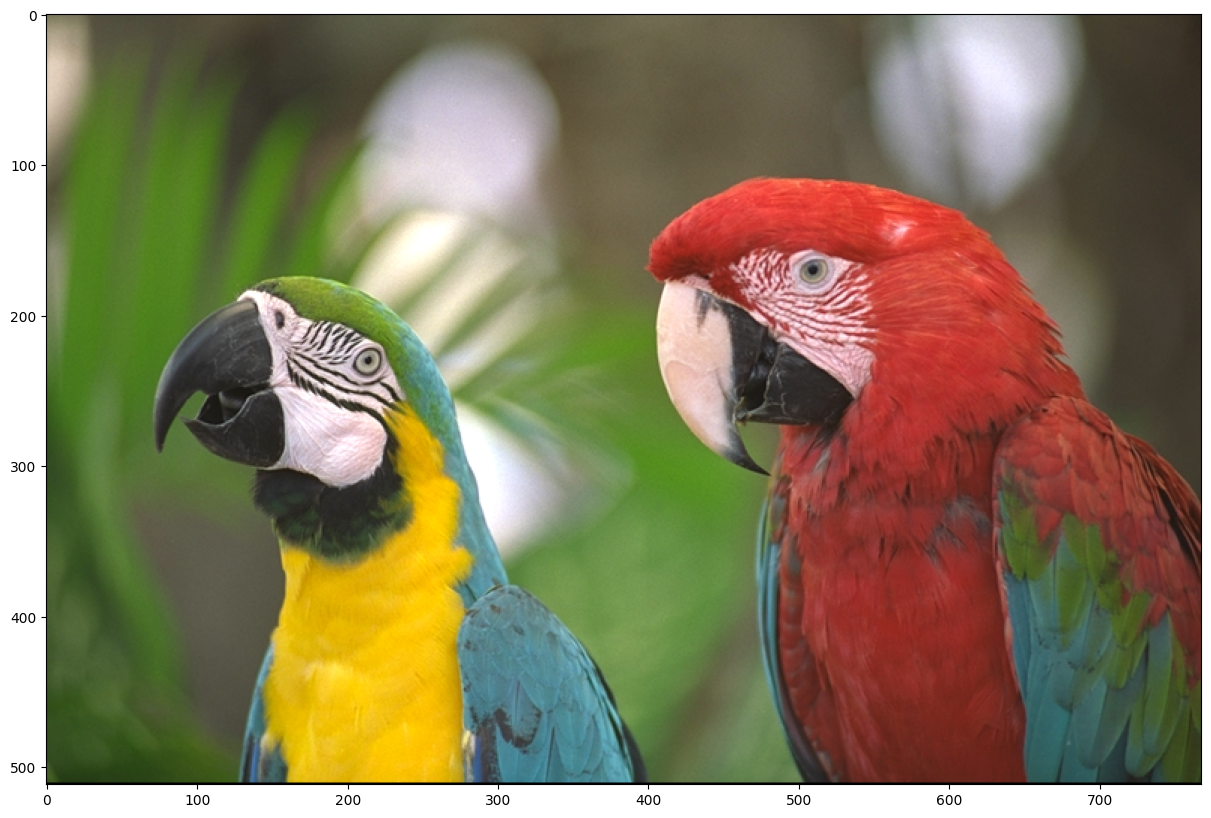

In [2]:
img = cv2.imread('data/kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 4-Color Palette

In [3]:
# Black, dark gray, light gray, white
colors_4 = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

In [4]:
def quantize_image(img, colors):
    img = img.astype(np.float32)
    rows, cols, channels = img.shape
    
    quantized = np.zeros_like(img)

    for r in tqdm(range(rows)):
        for c in range(cols):
            pixel = img[r, c]

            distances = np.linalg.norm(colors - pixel, axis=1)
            new_pixel = colors[np.argmin(distances)]

            quantized[r, c] = new_pixel

    return quantized


In [5]:
def fs_dithering(img, colors):
    img = img.astype(np.float32)
    rows, cols, channels = img.shape

    img_tmp = np.copy(img)
    dithering = np.zeros_like(img)

    for r in tqdm(range(1, rows - 1)):
        for c in range(1, cols - 1):
            pixel = img_tmp[r, c]

            distances = np.linalg.norm(colors - pixel, axis=1)
            new_pixel = colors[np.argmin(distances)]

            quant_error = pixel - new_pixel

            # Diffuse error
            img_tmp[r, c+1] += quant_error * 7/16
            img_tmp[r+1, c-1] += quant_error * 3/16
            img_tmp[r+1, c] += quant_error * 5/16
            img_tmp[r+1, c+1] += quant_error * 1/16

            dithering[r, c] = new_pixel

    return np.clip(dithering, 0, 255)


In [6]:
def compute_metrics(original, processed):
    """
    Computes MAE, MSE and PSNR between two images.
    
    Parameters:
        original  : original image (float32 or float64)
        processed : processed image (same shape as original)
        
    Returns:
        mae, mse, psnr
    """
    
    original = original.astype(np.float32)
    processed = processed.astype(np.float32)
    
    diff = original - processed
    
    mae = np.mean(np.abs(diff))
    
    mse = np.mean(diff ** 2)
    
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 10 * np.log10((255 ** 2) / mse)
    
    return mae, mse, psnr

In [8]:
def show_comparison(img1, img2,
                    title1="Optimally Quantized",
                    title2="Floyd-Steinberg Dithering",
                    metrics1=None,
                    metrics2=None):
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(np.clip(img1, 0, 255).astype(np.uint8))
    axes[0].set_title(title1)
    axes[0].axis("off")

    if metrics1 is not None:
        mae, mse, psnr = metrics1
        axes[0].text(
            0.5, -0.1,
            f"MAE: {mae:.2f} | MSE: {mse:.2f} | PSNR: {psnr:.2f} dB",
            ha="center",
            transform=axes[0].transAxes
        )

    axes[1].imshow(np.clip(img2, 0, 255).astype(np.uint8))
    axes[1].set_title(title2)
    axes[1].axis("off")

    if metrics2 is not None:
        mae, mse, psnr = metrics2
        axes[1].text(
            0.5, -0.1,
            f"MAE: {mae:.2f} | MSE: {mse:.2f} | PSNR: {psnr:.2f} dB",
            ha="center",
            transform=axes[1].transAxes
        )

    plt.tight_layout()
    plt.show()

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

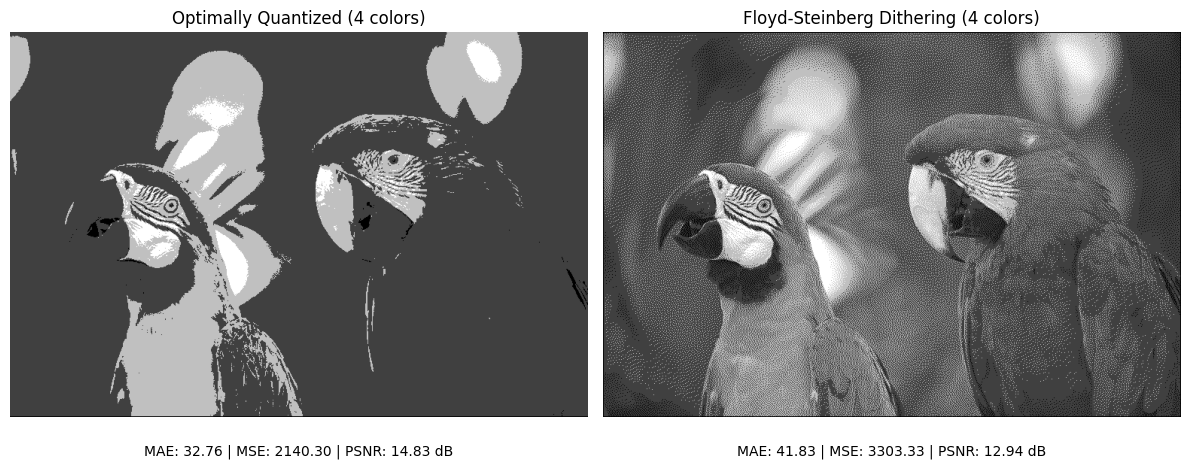

In [9]:
quantized_4 = quantize_image(img, colors_4)
dithering_4 = fs_dithering(img, colors_4)

metrics_q4 = compute_metrics(img, quantized_4)
metrics_d4 = compute_metrics(img, dithering_4)

show_comparison(
    quantized_4,
    dithering_4,
    "Optimally Quantized (4 colors)",
    "Floyd-Steinberg Dithering (4 colors)",
    metrics1=metrics_q4,
    metrics2=metrics_d4
)


## 2-Color Palette (Black & White)

In [11]:
colors_2 = np.array([
    [0, 0, 0],
    [255, 255, 255]
])

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

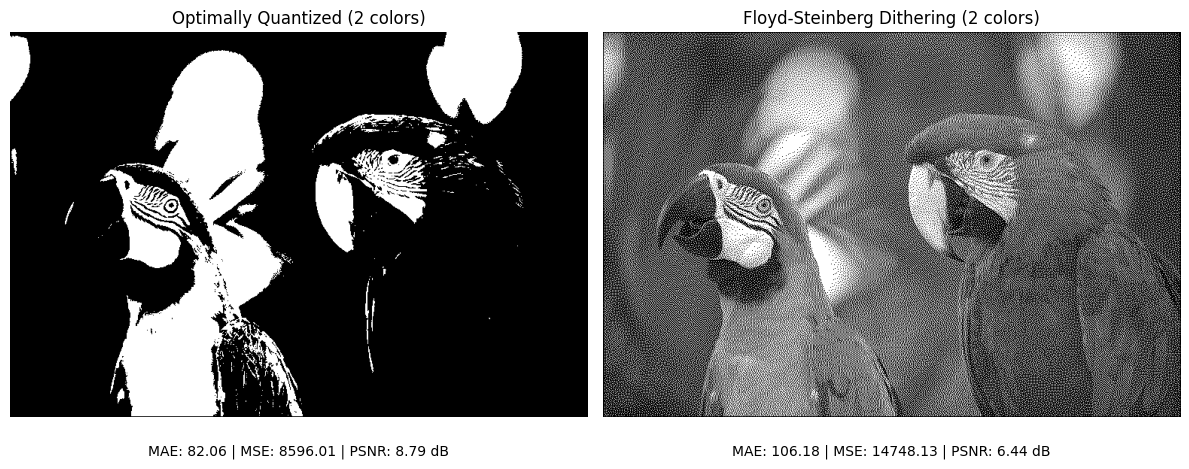

In [12]:
quantized_2 = quantize_image(img, colors_2)
dithering_2 = fs_dithering(img, colors_2)

metrics_q2 = compute_metrics(img, quantized_2)
metrics_d2 = compute_metrics(img, dithering_2)

show_comparison(
    quantized_2,
    dithering_2,
    "Optimally Quantized (2 colors)",
    "Floyd-Steinberg Dithering (2 colors)",
    metrics1=metrics_q2,
    metrics2=metrics_d2
)

## 16-Color Palette (K-means)

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

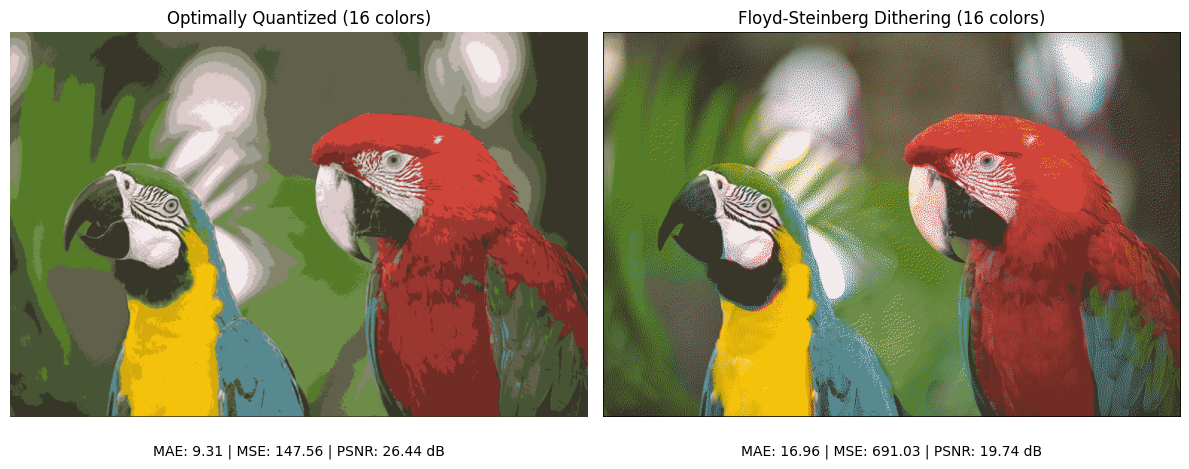

In [13]:
kmeans_16 = KMeans(n_clusters=16, random_state=42).fit(np.reshape(img, (-1, 3)))
colors_16 = kmeans_16.cluster_centers_

quantized_16 = quantize_image(img, colors_16)
dithering_16 = fs_dithering(img, colors_16)

metrics_q16 = compute_metrics(img, quantized_16)
metrics_d16 = compute_metrics(img, dithering_16)

show_comparison(
    quantized_16,
    dithering_16,
    "Optimally Quantized (16 colors)",
    "Floyd-Steinberg Dithering (16 colors)",
    metrics1=metrics_q16,
    metrics2=metrics_d16
)

## 32-Color Palette (K-means)

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

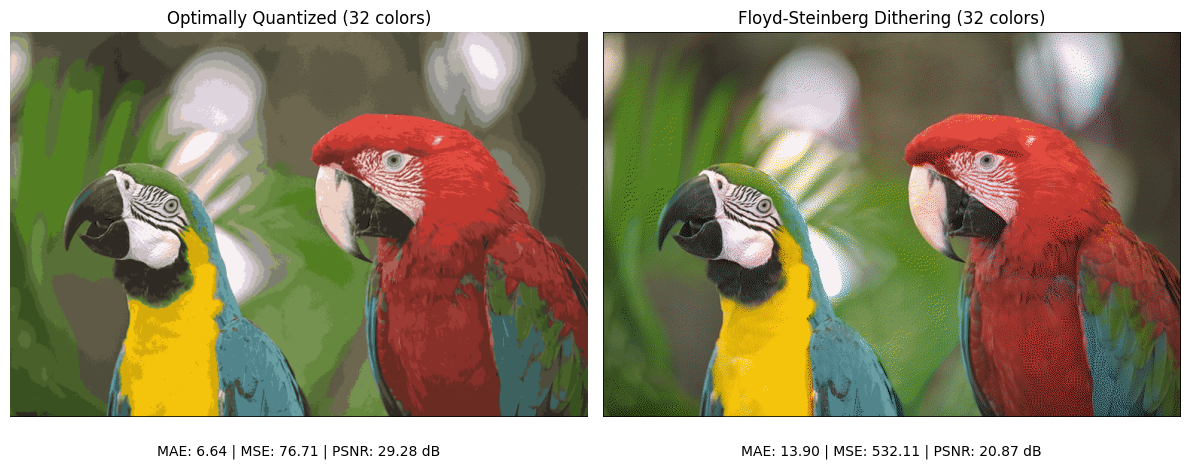

In [14]:
kmeans_32 = KMeans(n_clusters=32, random_state=42).fit(np.reshape(img, (-1, 3)))
colors_32 = kmeans_32.cluster_centers_

quantized_32 = quantize_image(img, colors_32)
dithering_32 = fs_dithering(img, colors_32)

metrics_q32 = compute_metrics(img, quantized_32)
metrics_d32 = compute_metrics(img, dithering_32)

show_comparison(
    quantized_32,
    dithering_32,
    "Optimally Quantized (32 colors)",
    "Floyd-Steinberg Dithering (32 colors)",
    metrics1=metrics_q32,
    metrics2=metrics_d32
)

## 256-Color Palette (K-means)

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/510 [00:00<?, ?it/s]

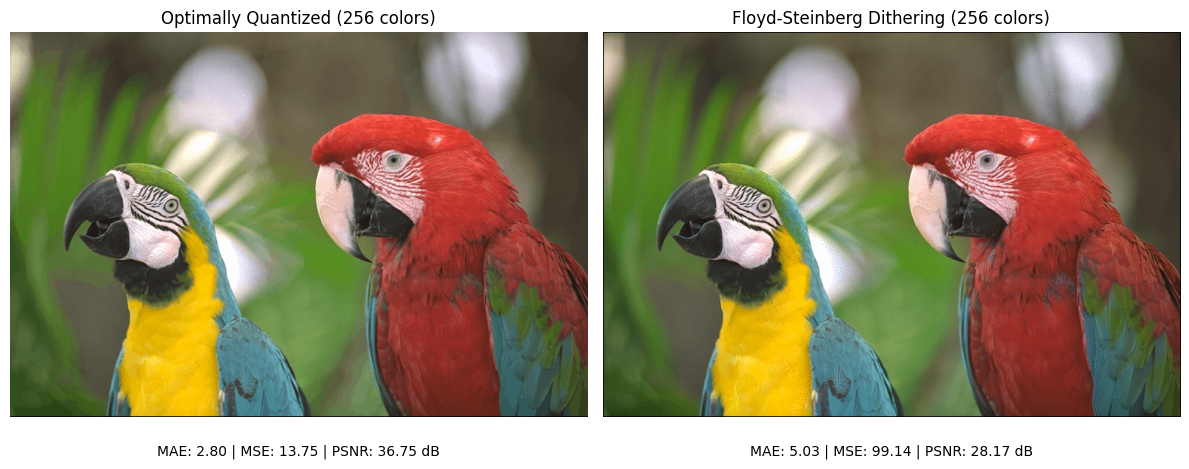

In [15]:
kmeans_256 = KMeans(n_clusters=256, random_state=42).fit(np.reshape(img, (-1, 3)))
colors_256 = kmeans_256.cluster_centers_

quantized_256 = quantize_image(img, colors_256)
dithering_256 = fs_dithering(img, colors_256)

metrics_q256 = compute_metrics(img, quantized_256)
metrics_d256 = compute_metrics(img, dithering_256)

show_comparison(
    quantized_256,
    dithering_256,
    "Optimally Quantized (256 colors)",
    "Floyd-Steinberg Dithering (256 colors)",
    metrics1=metrics_q256,
    metrics2=metrics_d256
)

## Comparison of Quantization and Dithering Across Different Palette Sizes

In [16]:
data = [
    [2,   "Quantization", *metrics_q2],
    [2,   "Dithering",    *metrics_d2],
    [4,   "Quantization", *metrics_q4],
    [4,   "Dithering",    *metrics_d4],
    [16,  "Quantization", *metrics_q16],
    [16,  "Dithering",    *metrics_d16],
    [32,  "Quantization", *metrics_q32],
    [32,  "Dithering",    *metrics_d32],
    [256, "Quantization", *metrics_q256],
    [256, "Dithering",    *metrics_d256],
]

df_metrics = pd.DataFrame(data, columns=["Colors", "Method", "MAE", "MSE", "PSNR"])

In [17]:
def plot_all_metrics(df):

    colors = df["Colors"].unique()
    x = np.arange(len(colors))
    width = 0.35

    df_quant = df[df["Method"] == "Quantization"]
    df_dith  = df[df["Method"] == "Dithering"]

    mae_q = df_quant["MAE"].values
    mae_d = df_dith["MAE"].values

    mse_q = df_quant["MSE"].values
    mse_d = df_dith["MSE"].values

    psnr_q = df_quant["PSNR"].values
    psnr_d = df_dith["PSNR"].values

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ---- MAE ----
    axes[0].bar(x - width/2, mae_q, width)
    axes[0].bar(x + width/2, mae_d, width)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(colors)
    axes[0].set_title("MAE")
    axes[0].set_xlabel("Number of Colors")
    axes[0].set_ylabel("MAE")
    axes[0].legend(["Quantization", "Dithering"])

    # ---- MSE (log scale) ----
    axes[1].bar(x - width/2, mse_q, width)
    axes[1].bar(x + width/2, mse_d, width)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(colors)
    axes[1].set_yscale("log")
    axes[1].set_title("MSE (log scale)")
    axes[1].set_xlabel("Number of Colors")
    axes[1].set_ylabel("MSE")
    axes[1].legend(["Quantization", "Dithering"])

    # ---- PSNR ----
    axes[2].bar(x - width/2, psnr_q, width)
    axes[2].bar(x + width/2, psnr_d, width)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(colors)
    axes[2].set_title("PSNR")
    axes[2].set_xlabel("Number of Colors")
    axes[2].set_ylabel("PSNR (dB)")
    axes[2].legend(["Quantization", "Dithering"])

    plt.tight_layout()
    plt.show()

In [18]:
df_metrics

Colors        Method         MAE           MSE       PSNR
0       2  Quantization   82.055878   8596.011719   8.787834
1       2     Dithering  106.181793  14748.126953   6.443435
2       4  Quantization   32.757751   2140.297852  14.826061
3       4     Dithering   41.831680   3303.327637  12.941287
4      16  Quantization    9.306087    147.556992  26.441206
5      16     Dithering   16.962008    691.033997  19.735809
6      32  Quantization    6.642984     76.708321  29.282379
7      32     Dithering   13.902057    532.111267  20.870779
8     256  Quantization    2.795675     13.752148  36.747098
9     256     Dithering    5.027926     99.143761  28.168150

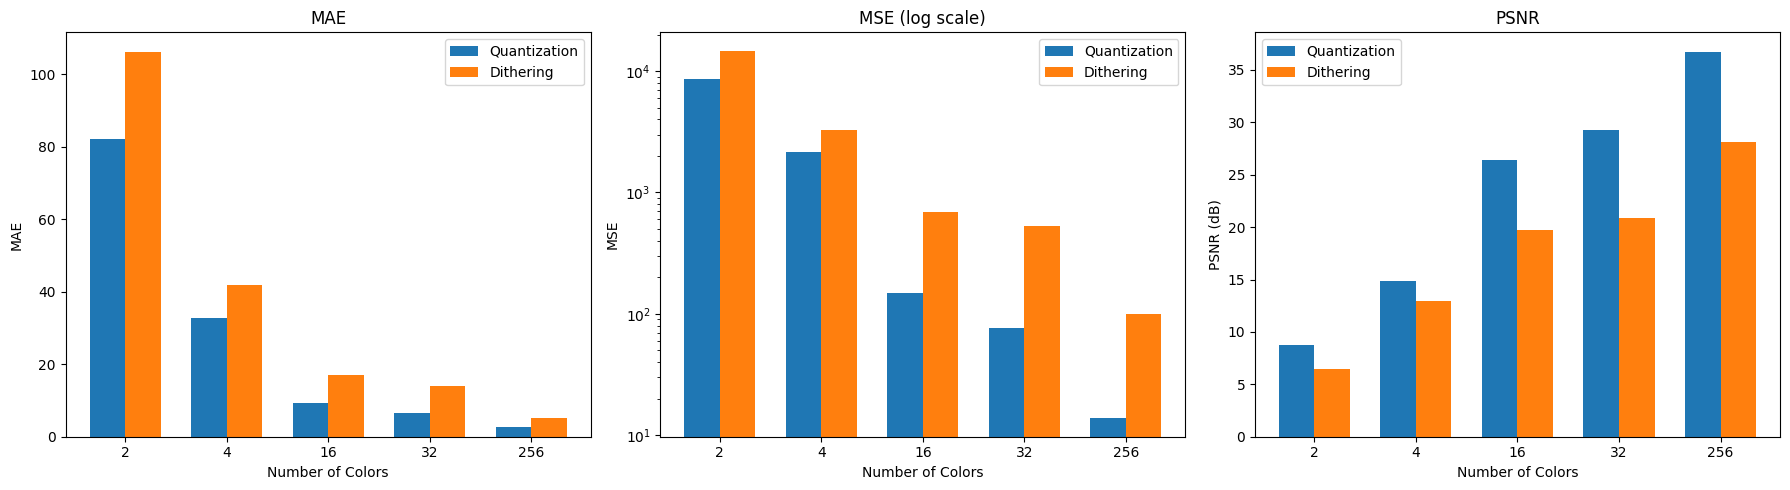

In [19]:
plot_all_metrics(df_metrics)

# Answers to the Questions

### Which image has higher quantization error? Optimally quantized or dithered?

The **dithered image has higher quantization error** in all tested cases (2, 4, 16, 32, and 256 colors).

This is clearly visible from the computed metrics:
- MAE is always higher for dithering.
- MSE is always higher for dithering.
- PSNR is always lower for dithering.

This happens because optimal quantization minimizes pixel-wise error directly, while Floyd–Steinberg dithering redistributes the quantization error to neighboring pixels instead of minimizing it locally.

---

### Which image looks better to you?

Although dithering has higher numerical error, it often looks better, especially when the number of colors is small.

- For 2 and 4 colors, dithering significantly improves visual quality.
- It reduces large flat regions and creates smoother perceptual transitions.
- A visible grain-like texture appears due to error diffusion.
- The human visual system prefers distributed high-frequency noise over large banding artifacts.

When the number of colors increases (16, 32, 256), the visual difference becomes much smaller.

---

### Can you repeat the same process using only two colours: black and white?
The same process was repeated with a 2-color palette (black and white).

**Results without dithering:**
- Severe posterization  
- Strong loss of detail  
- Large flat black and white regions  

**Results with Floyd–Steinberg dithering:**
- A grain-like structure appears due to error diffusion  
- Gray tones are perceptually simulated  
- Image details are better preserved visually  
This is the case where dithering has the strongest perceptual impact.

---

### How does the result look using a K-means palette?

Using a K-means palette significantly improves performance compared to fixed grayscale palettes.

Because K-means minimizes squared error (MSE), the selected colors better represent the original image distribution.

The quantized image becomes much closer to the original even without dithering.

---

### What happens if we use 32 colours?

With 32 colors:
- MAE and MSE decrease substantially.
- PSNR increases.
- The image looks very close to the original.
- The visual benefit of dithering becomes smaller.
- The grain-like effect becomes less noticeable.
Quantization artifacts are already minor at this level.

---

### What happens if we use 256 colours?

With 256 colors:
- Error becomes very small.
- PSNR becomes very high.
- The quantized image is almost indistinguishable from the original.
- Dithering becomes almost unnecessary.
- The grain-like texture is barely visible.
At this point, both methods converge visually.

---

### General Conclusion

1. Optimally quantized images always have lower numerical error.
2. Dithering increases numerical error but improves perceptual quality when the palette size is small.
3. The visible grain-like texture in dithered images is a natural consequence of error diffusion and helps reduce perceptual banding.
4. As the number of colors increases:
   - MAE decreases  
   - MSE decreases  
   - PSNR increases  
   - The difference between quantization and dithering diminishes.
5. Floyd–Steinberg dithering is most useful when the palette is very limited (2–4 colors).

In summary, dithering trades mathematical accuracy for perceptual improvement, especially in low-color scenarios.

